# CNN model construction of training_data_kok14_galfa

# Package Installation

In [19]:
import os 
import sys

In [20]:
# ! pip install astroML
# !pip install torch-lr-finder
# ! pip install pytorch-lightning

# Path

In [21]:
print(os.getcwd())

C:\Users\Administrator-1\HI


In [43]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

# Libraries

In [710]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

# Data preparation

In [319]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

In [320]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size= 0.2, random_state = 123)
#x_train = x_train.transpose()
#x_val = x_val.transpose()
#y_train = y_train.transpose()
#y_val = y_val.transpose()

In [321]:
print(f'x_train = {x_train.shape}, y_train = {y_train.shape}')
print(f'x_val = {x_val.shape}, y_val = {y_val.shape}')
print(f'X_test = {X_test.shape}, Y_test = {Y_test.shape}')

x_train = (31024, 414), y_train = (31024, 2)
x_val = (7757, 414), y_val = (7757, 2)
X_test = (58, 414), Y_test = (58, 2)


# Plot a few training samples

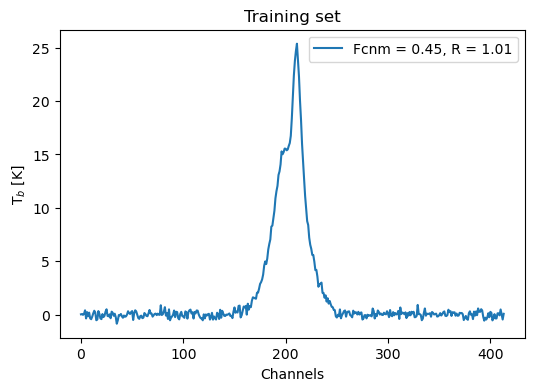

In [322]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

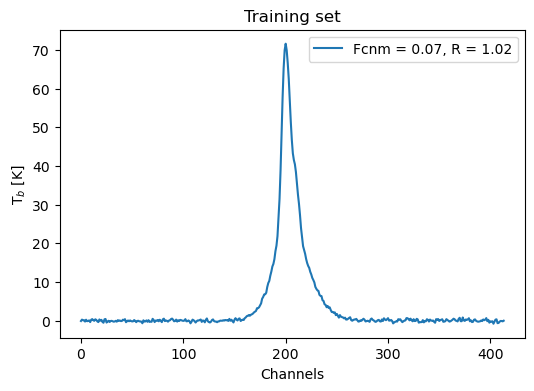

In [323]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

# Define Hyper-Parameters/Data loader

In [324]:
lr = 0.01
n_epoch = 100
loss = nn.MSELoss()

In [602]:
# data loader
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        spectra = self.x[idx,:]
        label = self.y[idx,:]
        #print(label)
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(1,spectra.shape[0])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [603]:
# transform to tenor 
class ToTensor():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        #x = x.view(1,x.shape[0])
        return x

In [604]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor(), target_transform=ToTensor())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor(), target_transform=ToTensor())
dataset_test = HI_dataset(X_test, Y_test,transform=ToTensor(), target_transform=ToTensor())

In [703]:
# initialize data loader
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [704]:
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 414])
torch.Size([20, 2])


# CNN Model

The CNN model below is the Model recurrence from paper: Extracting the cold neutral medium from HI emission with deep learning: Implications for Galactic
foregrounds at high latitude.

It contains 2 convolutional layers, 1 dropout layer and 1 fully connected layer. Model has input size 1x414 and output size 1x2.

In [693]:
import math
class Net_origin(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=8, num_output_2=8 ):
        super(Net_origin, self).__init__()
        # layers
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels=num_output_1, kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn1 = nn.BatchNorm1d(num_output_1)
        self.conv2 = nn.Conv1d(in_channels= num_output_1, out_channels=num_output_2, kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.dropout = nn.Dropout(0.30)
        self.bn2 = nn.BatchNorm1d(num_output_2)
        self.linear = nn.Linear(num_output_2 * 370, num_output)
        self.flatten = nn.Flatten()

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        #print(1, x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #print(3, x.size())
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        #print(4, x.size())
        return x

# Loss and Optimization

In [787]:
# training setting
lr = 0.005
num_epoch = 20
num_step = x_train.shape[0]/batch_size
loss_function = nn.MSELoss()
model = Net_origin()
best_err = 100000
optimizer = torch.optim.SGD(model.parameters(), lr)
device = torch.device('cude' if torch.cuda.is_available() else 'cpu' )

# Model Training and Evaluation 

In [788]:
# train 
def train(epoch):
    print('\nEpoch: %d' % epoch)
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss += loss.item()
        total += values.size(1)
        if (index+1)%300==0:
            print(f'epoch: {epoch+1}/{num_epoch}, step: {index+1}/{num_step}, avg_loss = {train_loss/total}')
            #print(f'truth = {values}, preditction = {outputs}, error = {loss.item()}')
            #print("outputs = ", outputs)
            #print(model.conv1.weight.grad) 

In [789]:
def validation(epoch):
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float() 
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss += loss.item()
            total += values.size(1)
            
    # Save checkpoint.
    error =  test_loss / total
    print('avg_validate_accuracy=', error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_err = error

In [790]:
def test(epoch):
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss += loss.item()
            total += values.size(1)
        print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')

In [791]:
# start training
for epoch in range(num_epoch):
    train(epoch)
    validation(epoch)
    if((epoch+1)%10==0):
        test(epoch)


Epoch: 0
epoch: 1/20, step: 300/1551.2, avg_loss = 0.18042886288370938
epoch: 1/20, step: 600/1551.2, avg_loss = 0.09694343209421884
epoch: 1/20, step: 900/1551.2, avg_loss = 0.06815433788863529
epoch: 1/20, step: 1200/1551.2, avg_loss = 0.0534396264370298
epoch: 1/20, step: 1500/1551.2, avg_loss = 0.04444616146401192
avg_validate_accuracy= 0.008558735660080481
best_err: 0.008558735660080481 Saving..

Epoch: 1
epoch: 2/20, step: 300/1551.2, avg_loss = 0.007971627198470136
epoch: 2/20, step: 600/1551.2, avg_loss = 0.007611386225131961
epoch: 2/20, step: 900/1551.2, avg_loss = 0.007554179289145395
epoch: 2/20, step: 1200/1551.2, avg_loss = 0.007281854517835503
epoch: 2/20, step: 1500/1551.2, avg_loss = 0.007120918659182887
avg_validate_accuracy= 0.006861781999684832
best_err: 0.006861781999684832 Saving..

Epoch: 2
epoch: 3/20, step: 300/1551.2, avg_loss = 0.006024692430704211
epoch: 3/20, step: 600/1551.2, avg_loss = 0.006221830184998301
epoch: 3/20, step: 900/1551.2, avg_loss = 0.0062

In [794]:
# model testing

model = Net_origin()
checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']

test(epoch)

Test performance in epoch 17: avg_error = 0.008892344155659279
